In [2]:
import pandas as pd
import re
from collections import Counter
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from goatools.base import get_godag
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Funzioni di supporto

def extract_GO_terms(row):
    row_str = ' '.join(row.astype(str))
    go_terms = re.findall(r'GO:\d+', row_str)
    unique_go_terms = list(set(go_terms))
    return unique_go_terms, row['protein_id']

def extract_ancestors(go_id):
    if go_id not in godag:
        return []
    term = godag[go_id]
    ancestors = term.get_all_upper()
    return [go_id] + list(ancestors)

def GO_enrichments(df, pvalue, refined=True, l=0, d=0, namespaces=None):
    df['GOs_and_protein'] = df.apply(extract_GO_terms, axis=1)

    go_to_proteins = {}

    newGOs_background = []
    for i, row in df.iterrows():
        for go in row['GOs_and_protein'][0]:
            ancestors = extract_ancestors(go)
            for ancestor in ancestors:
                GO = godag[ancestor].namespace + " - " + godag[ancestor].name + " L" + str(godag[ancestor].level) + " D" + str(godag[ancestor].depth)
                newGOs_background.append(GO)
                if GO not in go_to_proteins:
                    go_to_proteins[GO] = set(row['GOs_and_protein'][1])
                go_to_proteins[GO].add(row['GOs_and_protein'][1])

    background = newGOs_background
    if namespaces:
        background = [x for x in background if any(ns in x for ns in namespaces)]
    if l != 0:
        background = [x for x in background if int(x.split(" ")[-2][1:]) >= l]
    if d != 0:
        background = [x for x in background if int(x.split(" ")[-1][1:]) >= d]
    background = [x for x in background if "regulation" not in x]

    col = "pvalue_refined" if refined else "pvalue"
    df_cut = df[df[col] < pvalue]
    GOs = df_cut["GOs_and_protein"].apply(lambda x: x[0]).tolist()
    GOs = [item for sublist in GOs for item in sublist]
    GOs = [item for sublist in (extract_ancestors(x) for x in GOs) for item in sublist]
    #create new go_to_proteins that has only pids that are in df_cut['protein_id'].tolist()
    new_go_to_proteins = {}
    for go in go_to_proteins:
        new_go_to_proteins[go] = go_to_proteins[go].intersection(df_cut['GOs_and_protein'].apply(lambda x: x[1]).tolist())
        new_go_to_proteins[go] = [pid + " (" + df.loc[df['protein_id'] == pid, 'product'].values[0] + ")" for pid in new_go_to_proteins[go]]
    newGOs = []
    for x in GOs:
        GO = godag[x].namespace + " - " + godag[x].name + " L" + str(godag[x].level) + " D" + str(godag[x].depth)
        newGOs.append(GO)

    if namespaces:
        newGOs = [x for x in newGOs if any(ns in x for ns in namespaces)]
    if l != 0:
        newGOs = [x for x in newGOs if int(x.split(" ")[-2][1:]) >= l]
    if d != 0:
        newGOs = [x for x in newGOs if int(x.split(" ")[-1][1:]) >= d]
    newGOs = [x for x in newGOs if "regulation" not in x]

    GOs = Counter(newGOs)
    GOs_background = Counter(background)
    M = len(df)
    n = len(df_cut)

    if n == 0 or len(GOs) == 0:
        print("No GO terms meet the specified criteria. Try adjusting your filters.")
        return pd.DataFrame()
    
    p_values = {}
    enrichments = {}

    for go in GOs:
        N = GOs_background[go]
        x = GOs[go]
        if N > 0 and M > 0:
            enrichments[go] = (x / n) / (N / M)
            observed_frequency = x / n
            expected_frequency = N / M
            enrichment_score = observed_frequency / expected_frequency
            print(f"GO term: {go}")
            print(f"Observed frequency (x/n): {observed_frequency}")
            print(f"Expected frequency (N/M): {expected_frequency}")
            print(f"Enrichment score: {enrichment_score}")
            print("-" * 40)
            p_values[go] = hypergeom.sf(x - 1, M, N, n)
        else:
            enrichments[go] = 0
            p_values[go] = 1

    if len(p_values) == 0:
        print("No valid GO terms for enrichment analysis. Try adjusting your filters.")
        return pd.DataFrame()

    pvals = list(p_values.values())
    corrected_pvals_bonferroni = multipletests(pvals, method='bonferroni')[1]
    corrected_pvals_benjamini_hochberg = multipletests(pvals, method='fdr_bh')[1]

    data = {
        'GO term': list(p_values.keys()),
        'p-value': list(p_values.values()),
        'corrected p-value Bonferroni': corrected_pvals_bonferroni,
        'corrected p-value Benjamini-Hochberg': corrected_pvals_benjamini_hochberg,
        'associated_proteins': [', '.join(new_go_to_proteins.get(go, [])) for go in p_values.keys()]
    }
    dfGO = pd.DataFrame(data)
    dfGO['enrichment'] = dfGO['GO term'].map(enrichments)
    dfGO = dfGO.sort_values(by='p-value', ascending=True)
    return dfGO

# Carica il file di dati
url = 'https://raw.githubusercontent.com/DavideGotta/TESI/master/operoniscorestream.csv'
df = pd.read_csv(url)


# Carica il database GO
godag = get_godag('go-basic.obo', optional_attrs='relationship')

# Parametri per l'analisi
pvalue_threshold = 0.05
use_refined = True
min_level = 5
min_depth = 0
selected_namespaces = ["biological_process"]

# Esegui l'analisi di arricchimento genico
results = GO_enrichments(df, pvalue_threshold, refined=use_refined,
                         l=min_level, d=min_depth, namespaces=selected_namespaces)




  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms; optional_attrs(relationship)
GO term: biological_process - DNA recombination L6 D7
Observed frequency (x/n): 0.02262443438914027
Expected frequency (N/M): 0.019611890999174236
Enrichment score: 1.1536080019052155
----------------------------------------
GO term: biological_process - DNA metabolic process L5 D6
Observed frequency (x/n): 0.07239819004524888
Expected frequency (N/M): 0.0495458298926507
Enrichment score: 1.4612368024132731
----------------------------------------
GO term: biological_process - SOS response L5 D5
Observed frequency (x/n): 0.004524886877828055
Expected frequency (N/M): 0.0012386457473162675
Enrichment score: 3.653092006033183
----------------------------------------
GO term: biological_process - DNA repair L5 D7
Observed frequency (x/n): 0.01809954751131222
Expected frequency (N/M): 0.010941370767960363
Enrichment score: 1.654230342354649
----------------------------------------
GO te

In [4]:
godag = get_godag('go-basic.obo', optional_attrs='relationship')
go="GO:0009432"
godag[go].id

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms; optional_attrs(relationship)


GOTerm('GO:0009432'):
  id:GO:0009432
  item_id:GO:0009432
  name:SOS response
  namespace:biological_process
  _parents: 1 items
    GO:0006974
  parents: 1 items
    GO:0006974	level-04	depth-04	DNA damage response [biological_process]
  children: 0 items
  level:5
  depth:5
  is_obsolete:False
  alt_ids: 0 items
  relationship: 0 items
  relationship_rev: 0 items

In [31]:
pvalue_threshold = 0.01
use_refined = True
min_level = 5
min_depth = 0
selected_namespaces = ["molecular_function"]

# Esegui l'analisi di arricchimento genico
results = GO_enrichments(df, pvalue_threshold, refined=use_refined,
                         l=min_level, d=min_depth, namespaces=selected_namespaces)

GO term: molecular_function - ATP binding L5 D8
Observed frequency (x/n): 0.0273972602739726
Expected frequency (N/M): 0.02436003303055326
Enrichment score: 1.1246807522637567
----------------------------------------
GO term: molecular_function - adenyl nucleotide binding L6 D6
Observed frequency (x/n): 0.0273972602739726
Expected frequency (N/M): 0.030759702725020644
Enrichment score: 0.8906867702491496
----------------------------------------
GO term: molecular_function - purine nucleotide binding L5 D5
Observed frequency (x/n): 0.0273972602739726
Expected frequency (N/M): 0.03509496284062758
Enrichment score: 0.7806607574536664
----------------------------------------
GO term: molecular_function - adenyl ribonucleotide binding L5 D7
Observed frequency (x/n): 0.0273972602739726
Expected frequency (N/M): 0.026837324525185797
Enrichment score: 1.0208640674394098
----------------------------------------
GO term: molecular_function - single-stranded DNA binding L5 D5
Observed frequency (

In [32]:
results.to_excel('/home/davide/Desktop/GO01L5MP.xlsx')

In [20]:
results


,GO term,p-value,corrected p-value Bonferroni,corrected p-value Benjamini-Hochberg,associated_proteins,enrichment
13,molecular_function - rRNA (adenine) methyltran...,0.000020,0.001038,0.001038,WP_250121246.1 (16S rRNA (adenine(1518)-N(6)/a...,17.534842
15,molecular_function - rRNA methyltransferase ac...,0.000195,0.009935,0.004968,WP_250121246.1 (16S rRNA (adenine(1518)-N(6)/a...,5.479638
11,"molecular_function - rRNA (adenine-N6,N6-)-dim...",0.002073,0.105698,0.029982,WP_250121246.1 (16S rRNA (adenine(1518)-N(6)/a...,21.918552
12,molecular_function - S-adenosylmethionine-depe...,0.002498,0.127401,0.029982,WP_250121246.1 (16S rRNA (adenine(1518)-N(6)/a...,3.034876
14,molecular_function - N-methyltransferase activ...,0.002939,0.149912,0.029982,WP_250121246.1 (16S rRNA (adenine(1518)-N(6)/a...,6.262443
37,molecular_function - nucleobase-containing com...,0.004974,0.253651,0.041246,WP_250124546.1 (uracil phosphoribosyltransfera...,5.479638
6,molecular_function - double-stranded DNA bindi...,0.005661,0.288722,0.041246,WP_250121220.1 (transcriptional repressor LexA...,4.215106
9,molecular_function - sequence-specific double-...,0.007784,0.396962,0.049620,WP_250121220.1 (transcriptional repressor LexA...,4.870789
39,molecular_function - nucleoside kinase activit...,0.011698,0.596588,0.059659,WP_250124546.1 (uracil phosphoribosyltransferase),10.959276
4,molecular_function - single-stranded DNA bindi...,0.011698,0.596588,0.059659,WP_250122517.1 (single-stranded DNA-binding pr...,10.959276


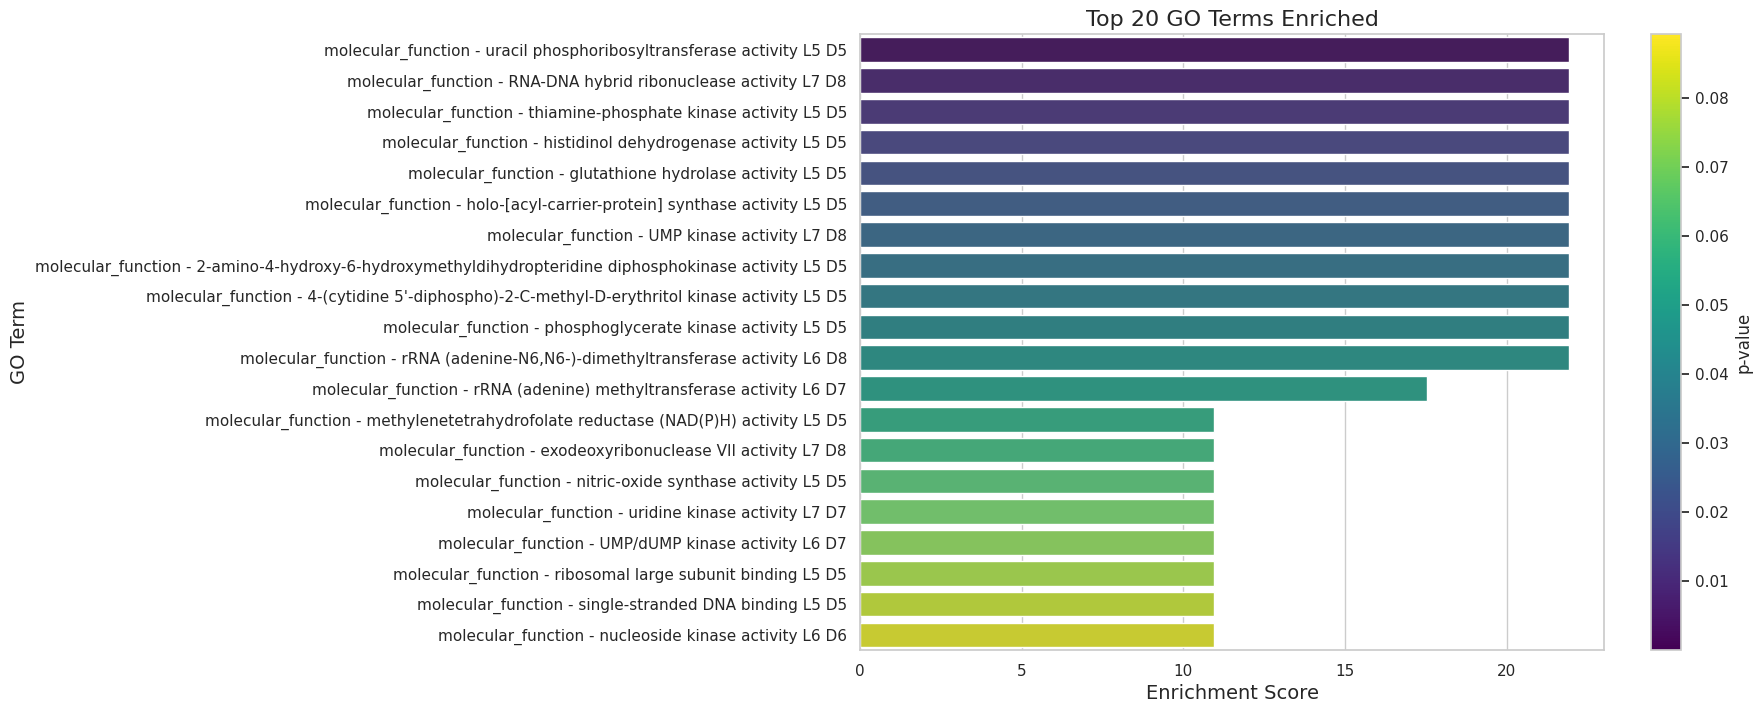

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordina il dataframe per enrichment in ordine decrescente e prendi i primi 20 termini
top_terms = results.sort_values('enrichment', ascending=False).head(20)

# Imposta lo stile di Seaborn
sns.set(style="whitegrid")

# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(12, 8))

# Crea il grafico a barre
bars = sns.barplot(x='enrichment', y='GO term', hue='GO term', data=top_terms, palette='viridis', legend=False)

# Aggiungi titoli e etichette
ax.set_title('Top 20 GO Terms Enriched', fontsize=16)
ax.set_xlabel('Enrichment Score', fontsize=14)
ax.set_ylabel('GO Term', fontsize=14)

# Aggiungi una barra di colore per il p-value
norm = plt.Normalize(top_terms['p-value'].min(), top_terms['p-value'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='p-value')

# Mostra il grafico
plt.show()

In [18]:
df

,operone,protein_id,score,pvalue,score_refined,pvalue_refined,product,gene,motivo,posizione,...,GOs_eggnog,GO_process,GO_component,GO_function,GO_process_pannzer2,KEGG_brite,pathways,locus_tag_iniziooperone,lunghezza_intergenica,GOs_and_protein
0,WP_250121493.1,WP_250121493.1,10.52,0.000000,21.05,0.000000,recombinase RecA,recA,TAGTATATCTGCACTA,-67,...,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...","['GO:0006281 - DNA repair [Evidence IEA]', 'GO...",['GO:0005737 - cytoplasm [Evidence IEA]'],"['GO:0003677 - DNA binding [Evidence IEA]', 'G...","['GO:0009432 - SOS response', 'GO:0006310 - DN...",ko03400 DNA repair and recombination proteins,Homologous recombination,LAU37_RS16010,300,"([GO:1901360, GO:0071704, GO:0008094, GO:00036..."
1,WP_250121220.1|WP_250121221.1,WP_250121220.1,10.21,0.000000,20.21,0.000000,transcriptional repressor LexA,lexA,TAGTACGAATGTTCTA,-48,...,"GO:0000976,GO:0001067,GO:0001130,GO:0001216,GO...",['GO:0006282 - regulation of DNA repair [Evide...,NaN,['GO:0004252 - serine-type endopeptidase activ...,NaN,"ko01002 Peptidases and inhibitors, ko03400 DNA...",NaN,LAU37_RS14470,128,"([GO:1902679, GO:0010557, GO:0003690, GO:00098..."
2,WP_250121220.1|WP_250121221.1,WP_250121221.1,10.21,0.000000,20.21,0.000000,DNA phosphorothioation system restriction enzyme,NaN,TAGTACGAATGTTCTA,-48,...,-,NaN,NaN,NaN,NaN,NaN,NaN,LAU37_RS14470,128,"([GO:0003677, GO:0005524, GO:0016787], WP_2501..."
3,WP_250121243.1|WP_250121244.1|WP_250121245.1|W...,WP_250121247.1,10.43,0.000000,19.30,0.000000,4-(cytidine 5'-diphospho)-2-C-methyl-D-erythri...,ispE,TAGTACATATGTACTA,-208,...,"GO:0003674,GO:0003824,GO:0006793,GO:0006796,GO...",['GO:0016114 - terpenoid biosynthetic process ...,NaN,"[""GO:0050515 - 4-(cytidine 5'-diphospho)-2-C-m...",NaN,NaN,"Metabolic pathways, Biosynthesis of secondary ...",LAU37_RS14595,300,"([GO:0008150, GO:0006793, GO:0016773, GO:00442..."
4,WP_250121243.1|WP_250121244.1|WP_250121245.1|W...,WP_250121246.1,10.43,0.000000,19.30,0.000000,16S rRNA (adenine(1518)-N(6)/adenine(1519)-N(6...,rsmA,TAGTACATATGTACTA,-208,...,"GO:0000154,GO:0000179,GO:0001510,GO:0003674,GO...",NaN,NaN,"['GO:0000179 - rRNA (adenine-N6,N6-)-dimethylt...",NaN,ko03009 Ribosome biogenesis,NaN,LAU37_RS14595,300,"([GO:1901360, GO:0022613, GO:0071704, GO:00081..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839,WP_250125029.1,WP_250125029.1,-6.74,0.995575,-6.85,0.997269,class I SAM-dependent methyltransferase,NaN,TTCAACAAAGGCAAAA,-18,...,-,NaN,NaN,NaN,NaN,NaN,NaN,LAU37_RS07855,24,"([], WP_250125029.1)"
4840,WP_250121957.1,WP_250121957.1,-7.02,0.996629,-7.02,0.997688,hypothetical protein,NaN,AGGGGTTAGGGTTAGA,-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAU37_RS18505,23,"([], WP_250121957.1)"
4841,WP_250125671.1,WP_250125671.1,-6.30,0.993292,-7.27,0.998273,phosphate ABC transporter permease,NaN,CAAAATCCAAAATCTA,-21,...,-,NaN,NaN,NaN,NaN,NaN,NaN,LAU37_RS11355,39,"([], WP_250125671.1)"
4842,WP_250121784.1|WP_250121785.1,WP_250121784.1,-7.28,0.997408,-7.36,0.998433,twin-arginine translocase subunit TatC,tatC,CTTTATATATCTCTGA,-17,...,"GO:0003674,GO:0005215,GO:0005575,GO:0005623,GO...",['GO:0015628 - protein secretion by the type I...,['GO:0005886 - plasma membrane [Evidence IEA]'],NaN,GO:0043953 - protein transport by the Tat complex,ko02044 Secretion system,"Protein export, Bacterial secretion system",LAU37_RS17575,24,"([GO:0044425, GO:0055085, GO:0034613, GO:00516..."


In [22]:
term="GO:0009432"
term_name = godag[term].name
term_namespace = godag[term].namespace
term_level = godag[term].level
term_depth = godag[term].depth
print(f"Term: {term} - {term_name}")

Term: GO:0009432 - SOS response


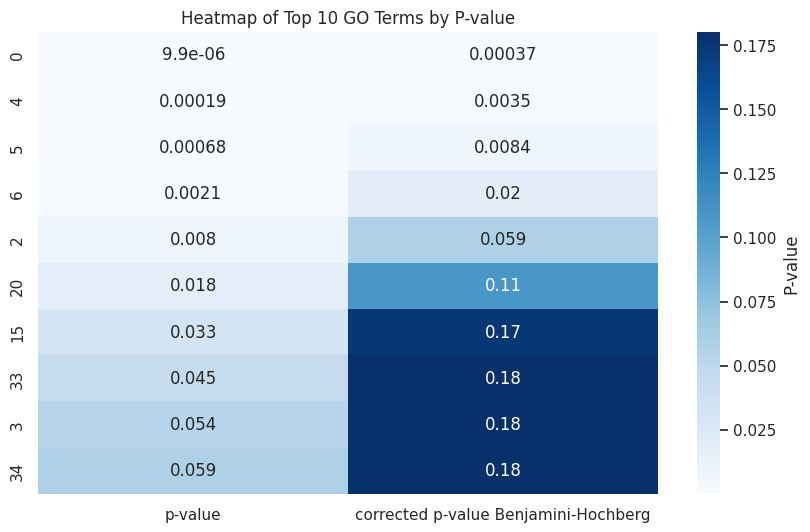

In [32]:
# Creiamo una heatmap dei p-value per i primi 10 GO terms
top_GO_terms_heatmap = results.sort_values(by='p-value').head(10)

plt.figure(figsize=(10, 6))
sns.heatmap(top_GO_terms_heatmap[['p-value', 'corrected p-value Benjamini-Hochberg']],
            annot=True, cmap='Blues', cbar_kws={'label': 'P-value'})
plt.title('Heatmap of Top 10 GO Terms by P-value')
plt.show()


In [2]:
import pickle
with open("/home/davide/PycharmProjects/TESI2/cds.pkl", "rb") as f:
    cds = pickle.load(f)

In [3]:
len(cds)

4256

In [6]:
for i in cds:
    print(i)
    print(cds[i])
    print(len(cds[i]))
    break

WP_250123955.1
['ATGTACGATTGCATCATCGTTGGTGCTGGTCCGGCTGGAGGATCGGCAGCCTATCATCTAGCGAAACAGGGGCGTTCGGTTTTAGTGCTAGAGAAAGAATCGCTCCCACGCTATAAACCTTGTGGGGGAGGCGTATCGCCTGAAGTTGCCAAATGGTTTGATTTTGATTTTTCTCCGGCGATTTCGGTAAAAGTTAATACCATTCGCTACACCTGGAAAATGGACGACCCCGTACAGGCTGAGTTACGCACGCCAGAACCGATGTGGATGGTGCGACGGGACGTATTCGATCGCTTCTTAGTTCAGCAGGCACAAAAACAAGGGGCAGAACTACGAGATAGTACGGAAGTTAACGGGATCGAATTTAAAGGCGATCGCTGGTACGTCAAAACTGCAAACCAAGTGTTTGAAGGACGTTATCTGATTGCAGCTGATGGCGCAAAAGGTCCAATGGCGAAGTGGTTGGGCTTCAAAGAACGCAAGCGCCGTTTGGGTGGTGCTTTAGAAGCAGAAGCCCCCGCCAAGGTGGATGATAGTAATATTGCCCATTTTGAATTCGGTATGGTCAAAAACGGCTATATCTGGAATTTCCCTAAAGCTGACGGCTATTCCATTGGTATCGGCACGTTTCGAGGTGGAGAAGGACAGGACTTTAAACAAATTTTGAGCGAATATGCCACTCTATTTGGCATTGATGTCAAGACTTGCAGACAATACGGTCATCCTCTCTGTTTGTGGGATGGAACGCAAAAACTTCATACTCAAAATGCCATTCTCGCTGGGGAAGCGGCTTGTGTCGTCGATCCATTCACGGCTGAAGGAATTCGTCCCTCAATCTTCACCGGAGTCAAAGCCGCAGCTGCGATCGATCGCGCGCTTGCAGGCGATATCAACGCCTTAGAACAATATACCGACACCATCAACGAAGAATGGGGCAGCGATATGGCTTGGGCGCAAAAACTAGCAGGTGTATTCTACCGCGT

In [7]:
with open("/home/davide/PycharmProjects/TESI2/cdsCCMEE29.pkl", "rb") as f:
    cdsCCMEE29 = pickle.load(f)

In [8]:
len(cdsCCMEE29)

5785